# Bottom-Up-Klassifikation

## Fragestellung

Was ist ein geeignetes Modell für die Bottom-Up-Klassifikation? Der Fokus der Untersuchung liegt nicht im detaillierten Vergleich von unterschiedlichen Klassifikator-Architekturen – vielmehr soll sichergestellt werden, dass in den nachfolgenden Versuchen eine ausreichend präzise Bottom-Up-Klassifikation erfolgt. Insbesondere muss der Klassifikator in der Lage sein, mit dem natürlichen und somit rauschbehafteten Input umgehen zu können.

## Hypothese/Vermutung

Es wird erwartet, dass Klassifikatoren besser abschneiden, die auf der Grundlage von natürlichen Bildern trainiert wurden. Ein Hintergrund dieser Hypothese ist (nach Van de Weijer et al), dass Farben im realen Kontext anders wahrgenommen werden als unter Laborbedingungen. Der stellenweise hochgradig störungsbehafteten Datengrundlage kann mutmaßlich mit einer flexiblen Architektur besser begegnet werden als mit einer starren Klassifikation, da ein flexibler Klassifikator besser in der Lage sein könnte auf etwaige regelmäßige Störanteile zu reagieren.
Ergebnisse auf dem Qualitätsniveau von Zarrieß & Schlangen oder Van de Weijer et al. werden explizit nicht erwartet: Obwohl auch in diesen Werken natürliche Bilder klassifiziert werden, liegen für die betreffenden Bildregionen Segmentationsmasken vor, anstatt dass die Bildregionen durch Bounding Boxes definiert sind. Dadurch werden Farbwerte um die betreffenden Objekte, welche die Klassifikation mutmaßlich in hohem Ausmaß erschweren, auf ein Minimum reduziert.

In Hinsicht auf die betrachteten Objektklassen (Color Diagnostic Objects, Color Biased Objects, Color Neutral Objects) ist bei der Bottom-Up-Klassifikation eine relative Gleichverteilung zu erwarten. Die betrachteten Objektklassen unterscheiden sich hinsichtlich dessen, ob die jeweiligen Objekte mit charakteristischen Farben assoziiert werden – es wird erwartet, dass diese Unterscheidung erst bei der Top-Down-Klassifikation relevant ist.

## Versuchsaufbau / Material

Als Material dient das gesamte extrahierte Korpus.

Es werden drei Klassifikatoren miteinander verglichen, die in zwei grundsätzliche Arten von Klassifikatoren eingeordnet werden können: 
Nach dem Vorbild von Zarrieß & Schlangen (2016) wird ein Klassifikator in Form eines künstlichen neuronalen Netzes implementiert. Bei dem Modell handelt es sich um einen mehrlagigen Perzeptron, das aus einem Input-Layer, einem Output-Layer und mehreren dazwischen liegenden Hidden-Layers besteht. Das Perzeptron wird mit einem Trainings-Set trainiert, als Input dienen normalisierte Farb-Histogramme, die mit OpenCV aus den jeweiligen Bildregionen extrahiert wurden. Die AutorInnen definieren das zugrundeliegende Klassifikationsproblem wie folgt: Der Input ist ein Merkmalsvektor x, der eine visuelle Repräsentation eines Referenten darstellt, der Output ist ein Label y, das eine Farbbezeichnung für den betrachteten Referenten darstellt. 	Die visuelle Repräsentation der Referenten besteht aus dreidimensionalen Farbhistogrammen mit 8 Bins pro Dimension, die automatisch aus den Bildregionen extrahiert wurden, die bei Visual Genome für die einzelnen Objekten annotiert sind. Der Input Layer entspricht demnach der Dimensionalität des Input-Vektors (in diesem Fall ein geflattetes 8*8*8-Histogramm - also einen Vektor der Form (512,)). Der Output-Layer besteht aus 11 Knoten (je einer für jedes betrachtete Basisfarbwort). Als Hidden Layers werden zwei Dense Layers mit 240 und 24 Knoten verwendet.

Gänzlich anders sind die beiden Klassifikatoren aufgebaut, die nach den Vorgaben von Van de Weijer et al. implementiert wurden. Beide Klassifikatoren analysieren die jeweiligen Bildausschnitte Pixel für Pixel, für jeden Bildpunkt erstellen sie im Anschluss eine Wahrscheinlichkeitsverteilung über Farbwörter. Schlussendlich wird der Durchschnitt der Vorhersagen für alle Pixel berechnet und als Vorhersage für das gesamte Bild herangezogen. Es findet somit auf Pixel-Ebene ein direktes Mapping von RGB-Werten auf Farbwörter statt. Der entscheidende Unterschied zwischen beiden Klassifikatoren besteht in der Datengrundlage, auf denen das Mapping beruht: Der Klassifikator Pixelwise-chip verwendet hierfür das Datenset von Benavente et al., das durch die Zuweisung von membership values für isolierte Farbreize unter Laborbedingungen entstand. Der Klassifikator Pixelwise-PLSA verwendet für das Mapping die von Van de Weijer et al. veröffentlichte Zuweisung von Wahrscheinlichkeitsverteilungen für RGB-Werte, die aus automatisch per Suchmaschine gesammelten Bildern beruht. Während Pixelwise-chip somit auf Urteilen für einzelne, abstrakte Farbreize beruht, entstand die Datengrundlage für Pixelwise-PLSA unter Zuhilfenahme von natürlichen Bildern, woraus eine größere Nähe zwischen Trainings- und Evaluationsdaten resultiert.
Als Input für beide Pixelwise-Klassifikatoren dienen die Matrizen der jeweiligen Bildausschnitte in Form eines dreidimensionalen Arrays.
Die Vorhersagen der Klassifikatoren werden durch gängige Evaluationskriterien verglichen. Hierfür werden Accuracy, Precision, Recall, F1-Score und Mean Reciprocal Rank herangezogen. Die Evaluation findet in Hinsicht auf unterschiedliche Objektgruppen statt (Alle Objekte, Color Diagnostic Objects, Color Neutral Objects, Color Biased Objects).

## Durchführung

Das Perzeptron wird mit einem Trainings-Set trainiert. Hyperparameter-Tuning findet nicht statt. Es werden die Parameter von Zarrieß & Schlangen übernommen: Um Overfitting zu verhindert wird ein Drop-Out von 0,2 verwendet, trainiert wird das Modell in 25 Epochen. 
Bei den Pixelwise-Klassifikatoren entfällt die Trainingsphase, da für das Mapping die Daten von Benavente et al. bzw. Van de Weijer et al. herangezogen werden.
Evaluiert werden alle Klassifikatoren mit demselben Test-Set.

## Beobachtete Ergebnisse

## Deutung

- Diskutieren unter Aspekten: 
    - Chip-based vs. Real-World-Daten
    - Ansatz mit maschinellem Lernen vs. reines Mapping

---

In [34]:
import pandas as pd
import numpy as np
import os
import sys
import configparser
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from collections import Counter

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']
input_dir = vg_json_export+'prediction_arrays/'

colors = preprocessing.basic_colors()

classifier_list = 'perceptron pixelwise_plsa pixelwise_chip'.split()

set_type = 'test'

# Diagramme etc als Graustufen anzeigen. Verwendung: greyscale(labels), ergibt Liste von Farbwerten
greyscale = lambda x: plt.cm.gray(np.linspace(0.2,0.8,len(x)))

### Prediction-Arrays importieren

In [35]:
Counter(np.load(vg_json_export+'feature_arrays/baseline_arrays_bgr_resampled.npz', allow_pickle=True)['train_y'][:,1:].argmax(axis=1))

Counter({0: 10000,
         1: 10000,
         2: 10000,
         3: 10000,
         4: 10000,
         5: 10000,
         6: 10000,
         7: 10000,
         8: 10000,
         9: 10000,
         10: 10000})

In [36]:
# Gezippte Numpy-Archive importieren
perceptron_arrays = np.load(input_dir+'results_perceptron_bgr.npz')
pixelwise_arrays = np.load(input_dir+'pixelwise_rgb_color.npz')

# Prediction-Arrays aus importierten Numpy-Dateien
perceptron_predict = perceptron_arrays['predict_'+set_type+'_y']
pixelwise_chip_predict = pixelwise_arrays[set_type+'_chip_w2c']
pixelwise_plsa_predict = pixelwise_arrays[set_type+'_w2c']

# IDs zu Perceptron-Prediction-Array hinzufügen (bei Pixelwise-Arrays bereits beinhaltet)
ids = perceptron_arrays[set_type+'_y'][:,0:1]
perceptron_predict = np.append(ids, perceptron_predict, axis=1)

In [37]:
perceptron_predict = pd.DataFrame(perceptron_predict).sort_values(by=0).to_numpy()
pixelwise_chip_predict = pd.DataFrame(pixelwise_chip_predict).loc[pd.DataFrame(pixelwise_chip_predict)[0].isin(perceptron_predict[:,0].ravel())].sort_values(by=0).to_numpy()
pixelwise_plsa_predict = pd.DataFrame(pixelwise_plsa_predict).loc[pd.DataFrame(pixelwise_plsa_predict)[0].isin(perceptron_predict[:,0].ravel())].sort_values(by=0).to_numpy()
ids = pixelwise_chip_predict[:,0].reshape(-1,1)
# Überprüfen, dass Shapes identisch sind
print ('Shapes identisch:',
       (perceptron_predict.shape == pixelwise_chip_predict.shape), 
       perceptron_predict.shape)
# Überprüfen, dass IDs identisch sind
print ('IDs identisch:',(not False in (perceptron_predict[:,0:1] == pixelwise_chip_predict[:,0:1])))

Shapes identisch: True (9053, 12)
IDs identisch: True


### DataFrames importieren + filtern, DataFrames für CDOs/CBOs/CNOs erstellen

In [38]:
all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
test_obj = pd.read_csv(vg_json_export+"extracted_data/"+set_type+"_df.csv", index_col=0)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)
# test_obj auf frequente Objekte reduzieren
freq_obj = all_obj.loc[perceptron_predict[:,0]]
# DataFrames für CDOs, CBOs und CNOs
cd_obj = freq_obj.loc[freq_obj.object_name.isin(color_diagnostic_objects.keys())]
cb_obj = freq_obj.loc[freq_obj.object_name.isin(color_biased_objects)]
#cb_obj = freq_obj.loc[np.logical_not(freq_obj.object_name.isin(list(color_diagnostic_objects.keys())+color_neutral_objects))]
cn_obj = freq_obj.loc[freq_obj.object_name.isin(color_neutral_objects)]

print ('Anzahl Einträge in DataFrames:',dict(zip(('freq_obj','cd_obj','cb_obj','cn_obj'),(len(freq_obj),len(cd_obj),len(cb_obj),len(cn_obj)))))
freq_obj, cd_obj, cn_obj, cb_obj = [df.loc[df.index.isin(ids.ravel())] for df in [freq_obj, cd_obj, cn_obj, cb_obj]]
print ('Anzahl Einträge in reduzierten DataFrames:', dict(zip(('freq_obj','cd_obj','cb_obj','cn_obj'),(len(freq_obj),len(cd_obj),len(cb_obj),len(cn_obj)))))

# Überprüfen, ob prediction-Arrays gleich viele Einträge haben wie freq_obj
print ('Identische Indizes für Prediction-Arrays und DataFrame:', perceptron_predict[:,0:1].ravel().astype(int).tolist() == freq_obj.index.tolist())

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Anzahl Einträge in DataFrames: {'cb_obj': 883, 'freq_obj': 9053, 'cn_obj': 1755, 'cd_obj': 1141}
Anzahl Einträge in reduzierten DataFrames: {'cb_obj': 883, 'freq_obj': 9053, 'cn_obj': 1755, 'cd_obj': 1141}
Identische Indizes für Prediction-Arrays und DataFrame: True


## Predictions und Test-DF zusammenführen
Resultat: Ein DF pro Bedingung (alle Objekte, CDO, CBO, CNO)

In [39]:
# DataFrames aus Predictions (np-Arrays) erstellen
perceptron_predict_df =  pd.DataFrame(data=perceptron_predict[0:,1:],index=perceptron_predict[0:,0],columns=colors)
pixelwise_chip_predict_df =  pd.DataFrame(data=pixelwise_chip_predict[0:,1:],index=pixelwise_chip_predict[0:,0],columns=colors)
pixelwise_plsa_predict_df =  pd.DataFrame(data=pixelwise_plsa_predict[0:,1:],index=pixelwise_plsa_predict[0:,0],columns=colors)

# Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
pred_label_perceptron = perceptron_predict_df.idxmax(axis=1)
pred_label_pixelwise_chip = pixelwise_chip_predict_df.idxmax(axis=1)
pred_label_pixelwise_plsa = pixelwise_plsa_predict_df.idxmax(axis=1)

# Predictions mit freq_obj kombinieren
predict_df = freq_obj.copy()
predict_df['perceptron_color'] = pred_label_perceptron
predict_df['pixelwise_chip_color'] = pred_label_pixelwise_chip
predict_df['pixelwise_plsa_color'] = pred_label_pixelwise_plsa

# DFs für CDOs, CNOs und CBOs
predict_cdo = predict_df.loc[cd_obj.index.to_list()]
predict_cbo = predict_df.loc[cb_obj.index.to_list()]
predict_cno = predict_df.loc[cn_obj.index.to_list()]

predict_df.head()

bb_h  bb_w  bb_x  bb_y  color  image_id  object_id       object_name  \
9.0     128    54   382   369   gray         1    1058531             pants   
68.0    102   372   425   132  brown         5    1060364           shelves   
206.0   121    42     1   335  white        12    1024188  computer monitor   
400.0   197   279   314     0  green        23    1024613              tree   
433.0   291   178   508   151  green        26    1061195         pine tree   

      perceptron_color pixelwise_chip_color pixelwise_plsa_color  
9.0               gray                black                 gray  
68.0             white                 gray                brown  
206.0             pink                 gray                brown  
400.0            green                black                green  
433.0            brown                black                black

## Objekte mit widersprüchlichen Farbattributen entfernen

# Informationen zu Train- und Test/Dev-Sets

### Train

In [40]:
print ('BottomUp-Classifier:\n')

train_perceptron_arrays = np.load(vg_json_export+'feature_arrays/'+'/baseline_arrays_bgr_resampled.npz', allow_pickle=True)
train_items = train_perceptron_arrays['train_y'][:,1:].argmax(axis=1)
print ('Train-Items: {items}\nItems pro Klasse: {classes}'
       .format(items=len(train_items),classes=dict(Counter(train_items)))
      )

min_group = min(Counter(train_items))
max_group = max(Counter(train_items))

print ('Kleinste Gruppe: {small}, größte Gruppe: {large}'
       .format(
           small=(min_group, Counter(train_items)[min_group]), 
           large=(max_group, Counter(train_items)[max_group])
       ))

BottomUp-Classifier:

Train-Items: 110000
Items pro Klasse: {0: 10000, 1: 10000, 2: 10000, 3: 10000, 4: 10000, 5: 10000, 6: 10000, 7: 10000, 8: 10000, 9: 10000, 10: 10000}
Kleinste Gruppe: (0, 10000), größte Gruppe: (10, 10000)


In [42]:
print ('Ganzes {}-set:\n'.format(set_type.capitalize()))

testdev_items = predict_df['color'].to_numpy()
total_items = len(predict_df)
items_per_class = dict(Counter(testdev_items))
print ('Items insgesamt: {items}\nItems pro Klasse:{classes}\n\n'.format(
    items= total_items,
    classes = items_per_class
))

Ganzes Test-set:

Items insgesamt: 9053
Items pro Klasse:{'black': 823, 'purple': 823, 'blue': 823, 'yellow': 823, 'brown': 823, 'green': 823, 'red': 823, 'pink': 823, 'gray': 823, 'white': 823, 'orange': 823}




### Test/Dev

Ganzes Test-set:

Items insgesamt: 9053
Items pro Klasse:{'black': 823, 'purple': 823, 'blue': 823, 'yellow': 823, 'brown': 823, 'green': 823, 'red': 823, 'pink': 823, 'gray': 823, 'white': 823, 'orange': 823}


cdo:
##########

Items : 1141
Durchschnitt Items/Klasse: 103.73
Items pro Klasse: {'black': 45, 'purple': 27, 'blue': 233, 'yellow': 39, 'gray': 85, 'green': 366, 'red': 27, 'pink': 17, 'brown': 73, 'white': 159, 'orange': 70}
Anteil Item an Gesamtmenge: [('green', 0.321), ('blue', 0.204), ('white', 0.139), ('gray', 0.074), ('brown', 0.064), ('orange', 0.061), ('black', 0.039), ('yellow', 0.034), ('red', 0.024), ('purple', 0.024), ('pink', 0.015)]


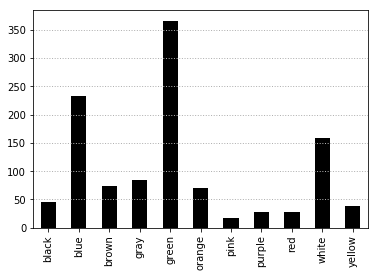

cbo:
##########

Items : 883
Durchschnitt Items/Klasse: 80.27
Items pro Klasse: {'black': 124, 'purple': 73, 'blue': 58, 'orange': 77, 'yellow': 72, 'gray': 73, 'red': 78, 'pink': 89, 'brown': 88, 'white': 99, 'green': 52}
Anteil Item an Gesamtmenge: [('black', 0.14), ('white', 0.112), ('pink', 0.101), ('brown', 0.1), ('red', 0.088), ('orange', 0.087), ('purple', 0.083), ('gray', 0.083), ('yellow', 0.082), ('blue', 0.066), ('green', 0.059)]


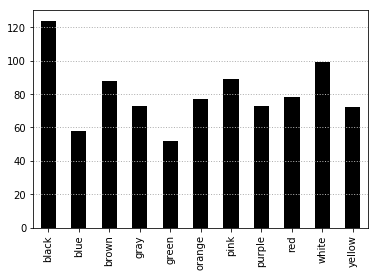

cno:
##########

Items : 1755
Durchschnitt Items/Klasse: 159.55
Items pro Klasse: {'black': 132, 'purple': 267, 'blue': 177, 'yellow': 125, 'brown': 106, 'green': 87, 'red': 185, 'pink': 256, 'gray': 157, 'white': 91, 'orange': 172}
Anteil Item an Gesamtmenge: [('purple', 0.152), ('pink', 0.146), ('red', 0.105), ('blue', 0.101), ('orange', 0.098), ('gray', 0.089), ('black', 0.075), ('yellow', 0.071), ('brown', 0.06), ('white', 0.052), ('green', 0.05)]


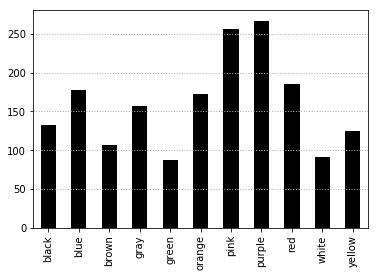

All:
##########



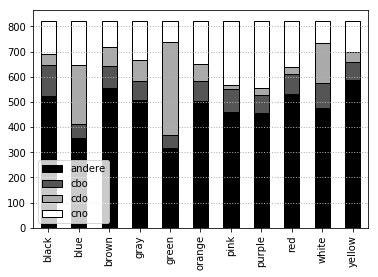

In [25]:
print ('Ganzes {}-set:\n'.format(set_type.capitalize()))

testdev_items = predict_df['color'].to_numpy()
total_items = len(predict_df)
total_items_per_class = Counter(testdev_items)
print ('Items insgesamt: {items}\nItems pro Klasse:{classes}\n\n'.format(
    items= total_items,
    classes = dict(total_items_per_class)
))

color_counts = dict()

for cl in 'cdo cbo cno'.split():
    print (cl+':\n'+'#'*10+'\n')
    
    testdev_items = eval("predict_"+cl+"['color'].to_numpy()")
    total_items = sum(Counter(testdev_items).values())
    items_per_class = Counter(testdev_items)
    total_items_per_class = total_items_per_class - items_per_class
    print ('Items : {items}\nDurchschnitt Items/Klasse: {average}\nItems pro Klasse: {classes}\nAnteil Item an Gesamtmenge: {percentage}'.format(
        items=total_items,
        average=round(total_items/len(items_per_class), 2),
        classes = dict(items_per_class),
        percentage = sorted(
            set(zip(
                list(items_per_class), 
                np.round(np.array(list(items_per_class.values()))/total_items, decimals=3))), 
            key=lambda elem:elem[1], reverse=True)
    ))
    
    # Verteilung Farbwörter plotten
    pd.Series(dict(Counter(testdev_items))).sort_index().plot.bar(cmap='gray')
    plt.gca().yaxis.grid(linestyle=':', linewidth=1)
    # als png speichern
    plt.savefig(vg_json_export+'images/'+'color_distribution_'+cl+'.png',bbox_inches="tight")
    plt.show()
    
    color_counts.update({cl:dict(Counter(testdev_items))})
    
print ('All:\n'+'#'*10+'\n')
# Unspezifizierte Objekte hinzufügen
color_counts.update({'andere':dict(Counter(total_items_per_class))})
# Verteilung Farbwörter plotten
pd.DataFrame(color_counts).plot.bar(stacked=True, colormap='gray', edgecolor='black')
plt.gca().yaxis.grid(linestyle=':', linewidth=1)
# als png speichern
plt.savefig(vg_json_export+'images/'+'color_distribution_testset.png',bbox_inches="tight")
plt.show()

# Ergebnisse überprüfen

In [10]:
accuracy_scores = {} 
print ('Accuracy')
for classifier in classifier_list:
    accuracy_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='accuracy'))
# accuracy_scores als LaTeX-Tabelle:
print (pd.DataFrame(accuracy_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=3).to_latex())

f1_scores = {} 
print ('f1')
for classifier in classifier_list:
    f1_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='f1', average='macro'))
# f1_scores als LaTeX-Tabelle:
#print (pd.DataFrame(f1_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=3).to_latex())

Accuracy
perceptron:
Metric: accuracy
{'Alle Objekte': 0.44250524687948745}
{'Color-Diagnostic Objects': 0.530236634531113}
{'Color-Biased Objects': 0.3827859569648924}
{'Color-Neutral Objects': 0.49173789173789173}


pixelwise_plsa:
Metric: accuracy
{'Alle Objekte': 0.3916933613166906}
{'Color-Diagnostic Objects': 0.5127081507449606}
{'Color-Biased Objects': 0.332955832389581}
{'Color-Neutral Objects': 0.43646723646723645}


pixelwise_chip:
Metric: accuracy
{'Alle Objekte': 0.22611289075444604}
{'Color-Diagnostic Objects': 0.3067484662576687}
{'Color-Biased Objects': 0.2332955832389581}
{'Color-Neutral Objects': 0.21766381766381768}


\begin{tabular}{lrrrr}
\toprule
{} &  Alle Objekte &  Color-Diagnostic Objects &  Color-Biased Objects &  Color-Neutral Objects \\
\midrule
perceptron     &         0.443 &                     0.530 &                 0.383 &                  0.492 \\
pixelwise\_chip &         0.226 &                     0.307 &                 0.233 &                  0.

## Alle Objekte

In [11]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_df['color'], predict_df[classifier+'_color']))
    columns = [c for c in colors]
    columns.append('macro avg')
    report = pd.DataFrame(classification_report(predict_df['color'], predict_df[classifier+'_color'], output_dict=True))\
        .drop(['support'], axis=0).drop(['weighted avg'], axis=1)\
        [columns]\
        .T[['precision', 'recall', 'f1-score']].round(decimals=3)\
    # LaTeX
    print (report.to_latex())

perceptron
              precision    recall  f1-score   support

       black       0.38      0.44      0.41       823
        blue       0.50      0.50      0.50       823
       brown       0.38      0.38      0.38       823
        gray       0.37      0.27      0.31       823
       green       0.49      0.56      0.52       823
      orange       0.43      0.46      0.44       823
        pink       0.53      0.49      0.51       823
      purple       0.62      0.46      0.53       823
         red       0.37      0.61      0.46       823
       white       0.34      0.15      0.21       823
      yellow       0.49      0.54      0.51       823

   micro avg       0.44      0.44      0.44      9053
   macro avg       0.44      0.44      0.44      9053
weighted avg       0.44      0.44      0.44      9053

\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
\midrule
black     &      0.384 &   0.439 &     0.409 \\
blue      &      0.501 &   0.501 &     0.501 \\

In [12]:
perceptron_report = pd.DataFrame(classification_report(predict_df['color'], predict_df['perceptron'+'_color'], output_dict=True))[colors].T
perceptron_report['prec-rec-diff'] = perceptron_report.apply(lambda x: x.precision - x.recall, axis=1)
perceptron_report['prec-rec-diff_abs'] = perceptron_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

plsa_report = pd.DataFrame(classification_report(predict_df['color'], predict_df['pixelwise_plsa'+'_color'], output_dict=True))[colors].T
plsa_report['prec-rec-diff'] = plsa_report.apply(lambda x: x.precision - x.recall, axis=1)
plsa_report['prec-rec-diff_abs'] = plsa_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

chip_report = pd.DataFrame(classification_report(predict_df['color'], predict_df['pixelwise_chip'+'_color'], output_dict=True))[colors].T
chip_report['prec-rec-diff'] = chip_report.apply(lambda x: x.precision - x.recall, axis=1)
chip_report['prec-rec-diff_abs'] = chip_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

In [122]:
metric = 'f1-score'

In [123]:
perceptron_report.sort_values(by=metric)
#perceptron_report.describe()
#print (perceptron_report.drop('gray white black'.split())['f1-score precision recall'.split()].describe().round(decimals=3))
#print (plsa_report.drop('gray white black'.split())['f1-score precision recall'.split()].describe().round(decimals=3))
#print (perceptron_report.loc['gray white black'.split()]['f1-score precision recall'.split()].describe().round(decimals=3))
#print (plsa_report.loc['gray white black'.split()]['f1-score precision recall'.split()].describe().round(decimals=3))

f1-score  precision    recall  support  prec-rec-diff  \
white   0.208754   0.339726  0.150668    823.0       0.189058   
gray    0.311978   0.365416  0.272175    823.0       0.093241   
brown   0.381412   0.378897  0.383961    823.0      -0.005064   
black   0.409297   0.383634  0.438639    823.0      -0.055005   
orange  0.442353   0.428734  0.456865    823.0      -0.028131   
red     0.458371   0.367572  0.608748    823.0      -0.241177   
blue    0.500608   0.500608  0.500608    823.0       0.000000   
pink    0.509114   0.527344  0.492102    823.0       0.035242   
yellow  0.511870   0.488938  0.537060    823.0      -0.048121   
green   0.521984   0.486856  0.562576    823.0      -0.075720   
purple  0.531663   0.622150  0.464156    823.0       0.157994   

        prec-rec-diff_abs  
white            0.189058  
gray             0.093241  
brown            0.005064  
black            0.055005  
orange           0.028131  
red              0.241177  
blue             0.000000  
pink             0.035242  
yellow           0.048121  
green            0.075720  
purple           0.157994

In [124]:
plsa_report.sort_values(by=metric)
#plsa_report.describe()

f1-score  precision    recall  support  prec-rec-diff  \
white   0.203470   0.289888  0.156744    823.0       0.133144   
gray    0.268999   0.244533  0.298906    823.0      -0.054374   
brown   0.361851   0.294073  0.470231    823.0      -0.176158   
black   0.366714   0.299080  0.473876    823.0      -0.174796   
orange  0.397563   0.532653  0.317132    823.0       0.215521   
pink    0.427075   0.633971  0.321993    823.0       0.311979   
purple  0.434988   0.618834  0.335358    823.0       0.283476   
yellow  0.438456   0.547273  0.365735    823.0       0.181538   
blue    0.459982   0.370096  0.607533    823.0      -0.237437   
red     0.461847   0.514158  0.419198    823.0       0.094960   
green   0.474721   0.422348  0.541920    823.0      -0.119571   

        prec-rec-diff_abs  
white            0.133144  
gray             0.054374  
brown            0.176158  
black            0.174796  
orange           0.215521  
pink             0.311979  
purple           0.283476  
yellow           0.181538  
blue             0.237437  
red              0.094960  
green            0.119571

In [125]:
chip_report.sort_values(by=metric)
#chip_report.describe()

f1-score  precision    recall  support  prec-rec-diff  \
white   0.065431   0.319149  0.036452    823.0       0.282697   
orange  0.132924   0.419355  0.078979    823.0       0.340375   
yellow  0.151316   0.775281  0.083840    823.0       0.691441   
purple  0.175620   0.586207  0.103281    823.0       0.482926   
red     0.184971   0.446512  0.116646    823.0       0.329865   
brown   0.224447   0.198140  0.258809    823.0      -0.060670   
black   0.240901   0.144337  0.727825    823.0      -0.583488   
gray    0.244582   0.179443  0.383961    823.0      -0.204518   
pink    0.253687   0.664948  0.156744    823.0       0.508205   
green   0.295858   0.322350  0.273390    823.0       0.048960   
blue    0.338462   0.461216  0.267315    823.0       0.193901   

        prec-rec-diff_abs  
white            0.282697  
orange           0.340375  
yellow           0.691441  
purple           0.482926  
red              0.329865  
brown            0.060670  
black            0.583488  
gray             0.204518  
pink             0.508205  
green            0.048960  
blue             0.193901

In [129]:
(plsa_report.sort_values(by=metric) - chip_report.sort_values(by=metric)).sort_values(by=metric)

f1-score  precision    recall  support  prec-rec-diff  \
gray    0.024417   0.065089 -0.085055      0.0       0.150144   
blue    0.121520  -0.091120  0.340219      0.0      -0.431338   
black   0.125813   0.154742 -0.253949      0.0       0.408691   
brown   0.137405   0.095933  0.211422      0.0      -0.115488   
white   0.138039  -0.029261  0.120292      0.0      -0.149553   
pink    0.173388  -0.030977  0.165249      0.0      -0.196226   
green   0.178863   0.099999  0.268530      0.0      -0.168531   
purple  0.259368   0.032627  0.232078      0.0      -0.199451   
orange  0.264638   0.113298  0.238153      0.0      -0.124855   
red     0.276876   0.067646  0.302552      0.0      -0.234905   
yellow  0.287140  -0.228008  0.281896      0.0      -0.509904   

        prec-rec-diff_abs  
gray            -0.150144  
blue             0.043536  
black           -0.408691  
brown            0.115488  
white           -0.149553  
pink            -0.196226  
green            0.070612  
purple          -0.199451  
orange          -0.124855  
red             -0.234905  
yellow          -0.509904

## CDOs

In [18]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_cdo['color'], predict_cdo[classifier+'_color']))

perceptron
              precision    recall  f1-score   support

       black       0.29      0.40      0.33        45
        blue       0.63      0.65      0.64       233
       brown       0.27      0.29      0.28        73
        gray       0.35      0.40      0.37        85
       green       0.78      0.64      0.70       366
      orange       0.48      0.69      0.57        70
        pink       0.29      0.35      0.32        17
      purple       0.26      0.26      0.26        27
         red       0.34      0.59      0.43        27
       white       0.48      0.30      0.37       159
      yellow       0.33      0.54      0.41        39

   micro avg       0.53      0.53      0.53      1141
   macro avg       0.41      0.46      0.43      1141
weighted avg       0.56      0.53      0.54      1141

pixelwise_plsa
              precision    recall  f1-score   support

       black       0.18      0.38      0.24        45
        blue       0.59      0.66      0.62       23

## CBOs

In [19]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_cbo['color'], predict_cbo[classifier+'_color']))

perceptron
              precision    recall  f1-score   support

       black       0.43      0.43      0.43       124
        blue       0.34      0.38      0.36        58
       brown       0.40      0.39      0.40        88
        gray       0.27      0.19      0.23        73
       green       0.35      0.46      0.40        52
      orange       0.31      0.31      0.31        77
        pink       0.48      0.45      0.47        89
      purple       0.60      0.40      0.48        73
         red       0.32      0.63      0.43        78
       white       0.30      0.11      0.16        99
      yellow       0.40      0.53      0.46        72

   micro avg       0.38      0.38      0.38       883
   macro avg       0.38      0.39      0.37       883
weighted avg       0.39      0.38      0.37       883

pixelwise_plsa
              precision    recall  f1-score   support

       black       0.37      0.36      0.37       124
        blue       0.26      0.53      0.35        5

## CNOs

In [20]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_cno['color'], predict_cno[classifier+'_color']))

perceptron
              precision    recall  f1-score   support

       black       0.38      0.51      0.44       132
        blue       0.53      0.51      0.52       177
       brown       0.35      0.42      0.38       106
        gray       0.42      0.21      0.28       157
       green       0.38      0.51      0.43        87
      orange       0.47      0.42      0.45       172
        pink       0.66      0.58      0.62       256
      purple       0.75      0.58      0.65       267
         red       0.39      0.65      0.49       185
       white       0.29      0.15      0.20        91
      yellow       0.50      0.58      0.54       125

   micro avg       0.49      0.49      0.49      1755
   macro avg       0.47      0.47      0.45      1755
weighted avg       0.51      0.49      0.49      1755

pixelwise_plsa
              precision    recall  f1-score   support

       black       0.33      0.69      0.45       132
        blue       0.35      0.62      0.45       17

## Mean Reciprocal Rank

In [21]:
# Werte von 0 bis 1, bester Wert 1
for classifier in classifier_list:
    print (classifier)
    print (round(
        evaluation.get_label_ranking_average_precision_score(pd.get_dummies(predict_df.color), eval(classifier+'_predict_df')),3
    ))
    print ('\n')

perceptron
0.616


pixelwise_plsa
0.579


pixelwise_chip
0.44




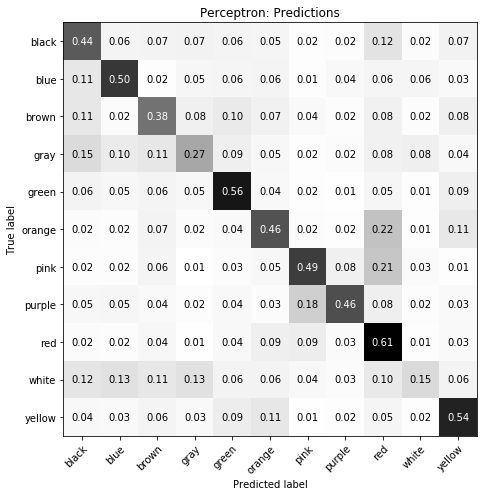

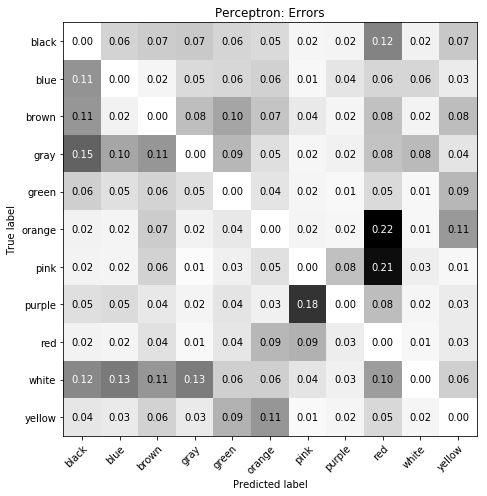

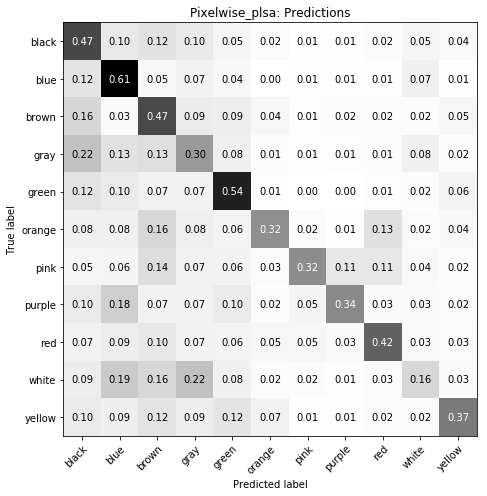

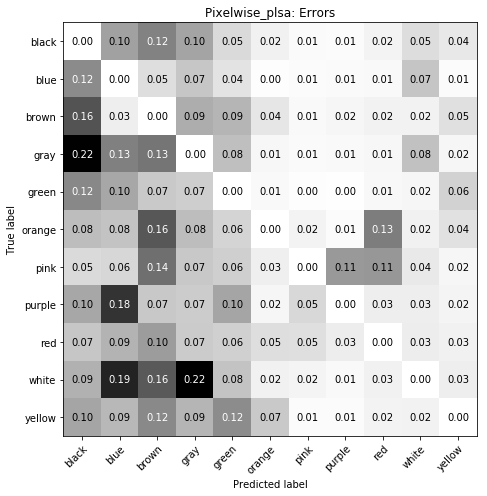

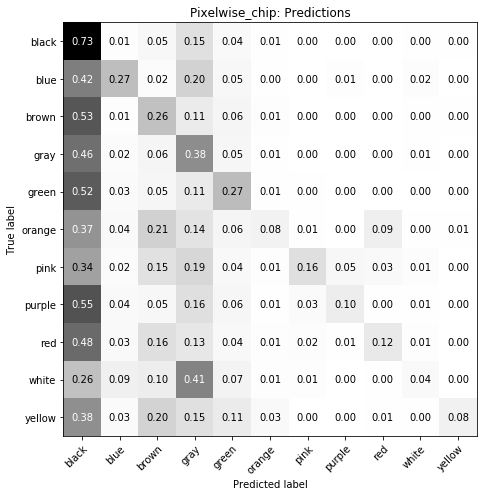

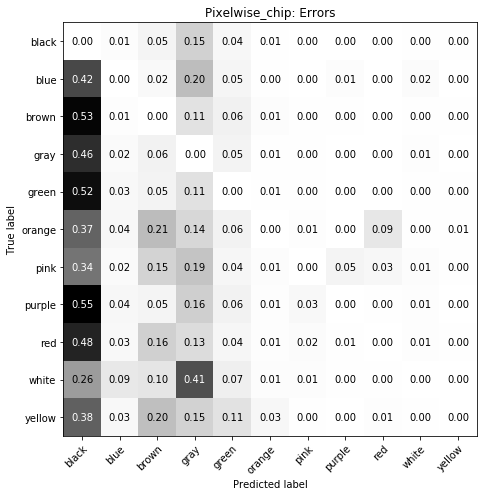

In [22]:
df = predict_df
save_image = True
for classifier in classifier_list:
    evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.capitalize() + ': Predictions', error_matrix=False, cmap=plt.cm.Greys, colorbar=False, save_image=save_image, file_dir = vg_json_export+'images/')
    evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.capitalize() + ': Errors', error_matrix=True, cmap=plt.cm.Greys, colorbar=False, save_image=save_image, file_dir = vg_json_export+'images/')

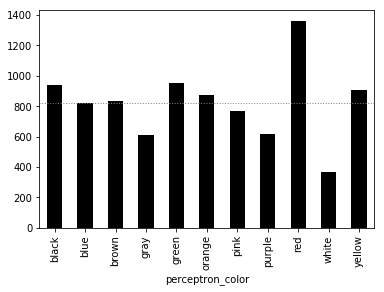

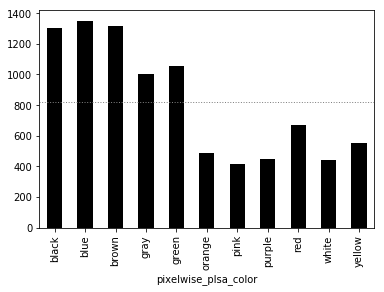

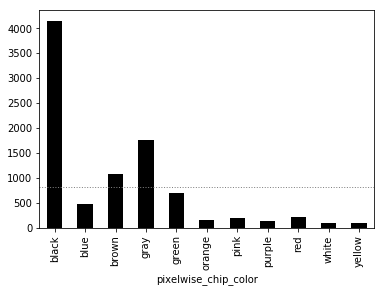

In [24]:
mean = predict_df.groupby('color').size().mean()

ax = predict_df.groupby('perceptron_color').size().plot.bar(color='black')
ax.axhline(mean,color='gray',linestyle=':',linewidth='1')
plt.savefig(vg_json_export+'images/'+'color_counts_bu_perceptron.png',bbox_inches="tight")
plt.show()

ax = predict_df.groupby('pixelwise_plsa_color').size().plot.bar(color='black')
ax.axhline(mean,color='gray',linestyle=':',linewidth='1')
plt.savefig(vg_json_export+'images/'+'color_counts_bu_plsa.png',bbox_inches="tight")
plt.show()

ax = predict_df.groupby('pixelwise_chip_color').size().plot.bar(color='black')
ax.axhline(mean,color='gray',linestyle=':',linewidth='1')
plt.savefig(vg_json_export+'images/'+'color_counts_bu_chip.png',bbox_inches="tight")
plt.show()


In [53]:
predict_cdo.groupby('color').size()['blue green white'.split()].sum() / len(predict_cdo)

0.6643295354951797